In [1]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from scipy.stats import chi2_contingency
from lifelines import KaplanMeierFitter
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.manifold import TSNE 
from bioinfokit.analys import stat
from scipy.stats import f_oneway
from xgboost import XGBClassifier
import matplotlib.pyplot as plt # matplotlib=3.1.2
from scipy.stats import chi2
import scipy.stats as stats
from sklearn import metrics
from scipy import stats
from sklearn import tree
from sklearn import svm
import seaborn as sns
import xlsxwriter
import statistics
import lifelines
import xgboost 
import pandas
import numpy 
import json
import umap
import shap 
import re

In [2]:
def separate_groups(data):
    
    MS = list()
    MM = list()
    SM = list()
    SAS = list()
    SAR = list()
    MAS = list()
    MAR = list()
    
    for i in data.values.tolist():
        if int(i[0]) == 1:
            MS.append(i[1:])
        if int(i[0]) == 2:
            MM.append(i[1:])
        if int(i[0]) == 3:
            SM.append(i[1:])
        if int(i[0]) == 4:
            SAS.append(i[1:])
        if int(i[0]) == 5:
            SAR.append(i[1:])
        if int(i[0]) == 6:
            MAS.append(i[1:])
        if int(i[0]) == 7:
            MAR.append(i[1:])
            
    return MS, MM, SM, SAS, SAR, MAS, MAR



def fit_model(x, y):    
    
    learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ]
    n_estimators = [7, 10, 13, 16]
    max_depth = [ 3, 4, 5, 6, 8, 10, 12, 15]
    max_depth.append(None)
    min_child_weight = [ 1, 3, 5, 7 ]
    colsample_bytree = [ 0.3, 0.4, 0.5 , 0.7 ]
    gamma = [ 0.0, 0.1, 0.2 , 0.3, 0.4 ]
    n_estimators = [7, 10, 13, 16]
    alpha = [8, 9, 10, 11, 12, 13]
    
    random_grid = {'learning_rate': learning_rate,
                   'n_estimators': n_estimators,
                   'max_depth': max_depth,
                   'min_child_weight': min_child_weight,
                   'colsample_bytree': colsample_bytree,
                   'gamma': gamma,
                   'alpha': alpha}
            
    clf = XGBClassifier()
    clf_random = RandomizedSearchCV(estimator = clf, 
                                    param_distributions = random_grid, 
                                    scoring = 'roc_auc',
                                    n_iter = 30, 
                                    cv = 5, 
                                    verbose = 2, 
                                    random_state = 42, 
                                    n_jobs = -1)
    clf_random.fit(x, y)

    best_parameters = clf_random.best_params_
    temp_text = json.dumps(clf_random.best_params_)
    
    return best_parameters 


def create_model(best_parameters, x, y, x_test, y_test, MM_SM):
    
    model = XGBClassifier(n_estimators = best_parameters['n_estimators'],
                          max_depth = best_parameters['max_depth'],
                          min_child_weight = best_parameters['min_child_weight'],
                          learning_rate = best_parameters['learning_rate'],
                          gamma = best_parameters['gamma'],
                          colsample_bytree = best_parameters['colsample_bytree'],
                          alpha = best_parameters['alpha'])

    model.fit(x,y) 
    y_pred = model.predict(x_test)
    print(metrics.classification_report(y_test, y_pred))
    
    yMM_SM_pred = model.predict(MM_SM)
    importances = model.feature_importances_
        
    #shapvalues
    mybooster = model.get_booster()
    model_bytearray = mybooster.save_raw()[4:]
    def myfun(self = None):
        return model_bytearray
    mybooster.save_raw = myfun

    # Shap explainer initilization
    shap_ex = shap.TreeExplainer(mybooster).shap_values(x)
    shap.summary_plot(shap_ex, x, plot_type = "dot", max_display=10)
    
    #model parameters
    print(model.get_params())
    
    return y_pred, yMM_SM_pred, importances, shap_ex



def KDE_plot(data1, data2, color1, color2, label1, label2, title, file):
    
    plt.figure(figsize = (10, 10))
    plt.rcParams["font.family"] = "times new roman"
    sns.kdeplot(data1, color = color1, label = label1, shade = True, shade_lowest = False, alpha = 0.66)
    sns.kdeplot(data2, color = color2, label = label2, shade = True, shade_lowest = False, alpha = 0.66)
    plt.legend(prop = {"size": 20}, loc = 'lower left')
    plt.title(title)
    plt.xlim(-30, 20)
    plt.ylim(-25, 25)
    plt.savefig(file, bbox_inches = 'tight', dpi = 300)
    
    return



def tsne_plot(classes, group, colors, legends):

    plt.figure(figsize =  (14, 14))
    plt.rcParams["font.family"] = "times new roman"
#     fig = fig.add_subplot(1,1,1)
    for label, color in zip(classes, colors):
            indicesToKeep = group == label
            plt.scatter(tsne_df.loc[indicesToKeep, 'dim1'], 
                        tsne_df.loc[indicesToKeep, 'dim2'], 
                        c = color, 
                        s = 200)
    plt.legend(legends,fontsize=40,loc='lower right',bbox_to_anchor=(0.5, 1.15))
    plt.grid()
    plt.xticks(fontsize=40)
    plt.yticks(fontsize=40)
    plt.grid(b=None,axis='both')
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.savefig(legends[0], bbox_inches='tight')
    return

def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = numpy.arange(len(tpr)) 
    roc = pandas.DataFrame({'tf' : pandas.Series(tpr-(1-fpr), index=i), 
                            'threshold' : pandas.Series(threshold, index=i),
                           'fpr': pandas.Series(fpr),
                            'tpr': pandas.Series(tpr)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return roc_t

def my_sum (data):
    if len(data)==0:
        return numpy.zeros(6)
    else:
        return numpy.array(data.sum(axis=0))
    
def categorize(group1, group2, symp_index, group1_label, group2_label):
    group1_zero = numpy.count_nonzero(group1[:, symp_index] == 0)
    group1_nonzero = numpy.count_nonzero(group1[:, symp_index] != 0)
    
    group2_zero = numpy.count_nonzero(group2[:, symp_index] == 0)
    group2_nonzero = numpy.count_nonzero(group2[:, symp_index] != 0)
    
    print(group1_zero)
    print(group1_nonzero)
    print(group2_zero)
    print(group2_nonzero)
    
    ## rows: AS-like, AR-like
    ## columns: zero, nonzero
    
    df = pandas.DataFrame([[group1_zero, group1_nonzero],[group2_zero, group2_nonzero]],
                  index=pandas.Index([group1_label, group2_label], name='Group'),
                  columns=pandas.Index(['zero', 'nonzero'], name='Value'))
    
    print(df.head())
    stat, p, dof, expected = chi2_contingency(df)
    print('dof=%d' % dof)
    print(expected)
    # interpret test-statistic
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    print('critical: '+str(critical))
    print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
    if abs(stat) >= critical:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    # interpret p-value
    alpha = 1.0 - prob
    print('significance=%.3f, p=%.3f' % (alpha, p))
    chip_values.append(p)
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
        
    if group1_zero == 0 or group1_nonzero ==0 or group2_zero==0 or group2_nonzero==0:
        print('Fisher exact test:')
        print(stats.fisher_exact(df))

In [3]:
#Raw Data Collection
raw_data = pandas.read_excel('/Users/Rashmi/Desktop/Oct29.xlsx')
y = raw_data[raw_data.columns[2]]

x_features_to_train = ['MV_E_vel_cm_sec','MV_A_vel','E_A','MV_Decel_Time',"Mve'_lat","Mve'_sep","E/e'_lat","E/e'_sep",'4CH strain','LA EF',
    'LA Strain','Cont Str','Conduit St','LA(CTTP)','LV(CTTP)%','EDV Indexed','ESV indexed','CI',
    'SV','LV mass Index','LA V indexed','RWT (ED)','LV Mass/ volume ratio',
    'EF BP','LA pressure','Ao_sinus_cm','LVOT_cm','AscAo_cm','LVIDd_mm','LVESd_mm',
    'IVSd_mm','PWTd_mm','IVSs','PWTs']

Display_columns_train = ['E wave velocity (cm/sec)', 'A wave velocity (cm/sec)','E/A','Mitral valve Deceleration Time (s)', 'E lateral',
                  'E septal','E/e lateral','E/e septal', 'LV GLS (%)','LA EF (%)','LA Strain (%)',
                  'Contractile Strain (%)','Conduit Strain (%)','LA (Corrected Time to Peak) %',
                  'LV (Corrected Time to Peak) %','LV EDVi (ml/m2)',
                  'LV ESVi (ml/m2)','Cardiac Index (L/min-m2)','Stroke volume (ml)',
                    'LV mass indexed (mg/m2)','LA volume indexed (ml/m2)',
                    'LV RWT','LV Mass/LV Volume (g/ml)','LV EF (%)',
                        'LA Pressure (mmHg)','Aortic sinus (cm)','LVOT diameter (cm)','AscAo diameter (cm)','LV EDd (mm)',
                        'LV ESd (mm)','IVSd (mm)','PWTd (mm)','IVSs (mm)','PWTs (mm)']

all_columns_raw=raw_data.columns[3:]


Display_columns_all = ['Vmax(m/s)','Mean gradient (mmHg)','Peak gradient (mmHg)','Velocity time integral (m)','Aortic valve area (cm2)',
    'Indexed Aortic valve area (cm2/m2)','Dimensionless Velocity Ratio','AR Jet Grade','Age','Gender','BSA',
    'Vena contracta (cm)','AR jet width (cm)','AR width LVOT (cm)','AR jet LVOT ratio','AR Pressure Half Time (s)',
    'AR End Systolic Pressure (mmHg)','AR End Diastolic Pressure Gradient (mmHg)', 
                     "E velocity (cm/sec)", "A velocity (cm/sec)",'E/A','Mitral valve Deceleration Time ', 'E lateral',
                  'E septal','E/e lateral','E/e septal', 'Absolute LV strain (%)','LA EF (%)','LA Strain (%)',
                  'Contractile Strain (%)','Conduit Strain (%)','LA (Corrected Time to Peak) %',
                  'LV (Corrected Time to Peak) %','End Diastolic Volume(ml)','End Diastolic Volume Indexed (ml/m2)',
                  'End Systolic Volume(ml)','End Systolic Volume Indexed (ml/m2)','Cardiac Output (L/min)',
                      'Cardiac Index (L/min-m2)','Stroke volume (ml)','LV mass(mg)','LV mass indexed (mg/m2)',
                      'LA volume(ml)','LA volume indexed (ml/m2)','Relative Wall Thickness','LV Mass/LV Volume (kg/m3)','Left ventricular Ejection Fraction (%)',
                        'LA Pressure (mmHg)','Aortic sinus (cm)','LVOT (cm)','AscAo (cm)','LV Peak Pressure (mmHg)',
                      'LVIDd (mm)','LVESd (mm)','IVSd (mm)','PWTd (mm)','IVSs','PWTs']

In [4]:
# Analyze data (features used ) for training
[MS, MM, SM, SAS, SAR, MAS, MAR] = separate_groups(raw_data[['Group'] + ['Study_No']+ x_features_to_train])

yMS = numpy.full((len(MS), 1), 1)
yMM = numpy.full((len(MM), 1), 2)
ySM = numpy.full((len(SM), 1), 3)
ySAS = numpy.full((len(SAS), 1), 4)
ySAR = numpy.full((len(SAR), 1), 5)
yMAS = numpy.full((len(MAS), 1), 6)
yMAR = numpy.full((len(MAR), 1), 7)

print('MS: '+str(len(yMS)))
print('MM: '+str(len(yMM)))
print('SM: '+str(len(ySM)))
print('SAS: '+str(len(ySAS)))
print('SAR: '+str(len(ySAR)))
print('MAS: '+str(len(yMAS)))
print('MAR: '+str(len(yMAR)))

MS_MM_SM = numpy.concatenate((MS, MM, SM))
SAS_SAR_MAS_MAR = numpy.concatenate((SAS, SAR, MAS, MAR))
MS_MM_SM=pandas.DataFrame(MS_MM_SM)
SAS_SAR_MAS_MAR=pandas.DataFrame(SAS_SAR_MAS_MAR)

# Convert to DataFrame and then place back column names into both the MM_SM and SAS_SAR_MAS_MAR - called x_features_to_train
yMS_MM_SM = numpy.concatenate((yMS, yMM, ySM))
ySAS_SAR_MAS_MAR = numpy.concatenate((ySAS, ySAR, yMAS, yMAR))

MS: 7
MM: 40
SM: 56
SAS: 60
SAR: 51
MAS: 81
MAR: 48


In [5]:
# Normalization
X_train, X_test, y_train, y_test = train_test_split(SAS_SAR_MAS_MAR.iloc[:,1:], 
                                                    ySAS_SAR_MAS_MAR, 
                                                    test_size = 0.20, 
                                                    random_state = 42)

scaler = StandardScaler()
scaler.fit(X_train)

# Normalize X_train to unit variance
normalized_train = pandas.DataFrame(scaler.transform(X_train))
normalized_train.columns = x_features_to_train
normalized_train.insert(0, 'Group', y_train)
train_length=len(normalized_train)

# Normalize X_test with mean and std of X_train
normalized_test = pandas.DataFrame(scaler.transform( X_test ))
normalized_test.columns = x_features_to_train
normalized_test.insert(0, 'Group', y_test)

# Class MS MM SM normalized by mean and variance of X_train
normalized_MS_MM_SM = pandas.DataFrame(scaler.transform(MS_MM_SM.iloc[:,1:]))
normalized_MS_MM_SM.columns = x_features_to_train
normalized_MS_MM_SM.insert(0, 'Group', yMS_MM_SM)

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


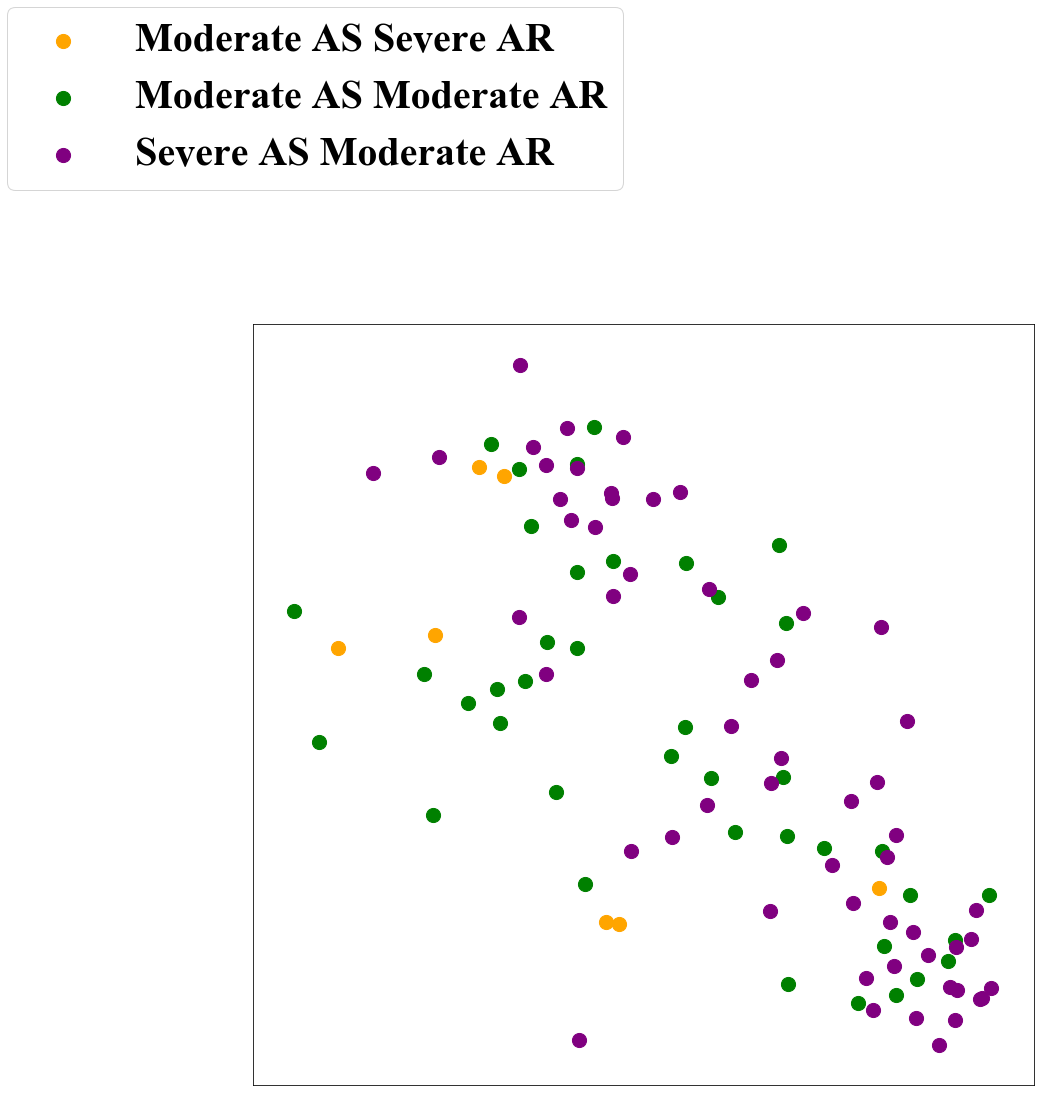

In [6]:
# Visualize data with tsne

all_normalized = numpy.concatenate((normalized_train, normalized_MS_MM_SM))
all_normalized = pandas.DataFrame(all_normalized)


tsne = TSNE(n_components = 2,random_state = 42)
y_tsne = tsne.fit_transform(all_normalized.iloc[:,1:])

tsne_df = pandas.DataFrame(columns = [0,1,2])
tsne_df[0] = numpy.asarray(all_normalized.iloc[:,0])
tsne_df[1] = y_tsne[:,0]
tsne_df[2] = y_tsne[:,1]

[MS_t, MM_t, SM_t, SAS_t, SAR_t, MAS_t, MAR_t] = separate_groups(tsne_df)

xtrainingAS_t = pandas.DataFrame(numpy.concatenate((SAS_t, MAS_t)))
xtrainingAR_t = pandas.DataFrame(numpy.concatenate((SAR_t, MAR_t)))

#Adding other relevant labels to the tsne dataframe for display
n=0
for i in tsne_df[0]:
    if i ==4 or i==6:
        tsne_df.at[n,3]=0
        tsne_df.at[n,4]=0
    if i==5 or i==7:
        tsne_df.at[n,3]=1
        tsne_df.at[n,4]=0
    if i==1 or i==2 or i==3:
        tsne_df.at[n,3]=2
        tsne_df.at[n,4]=1
    n=n+1
    
tsne_df.columns = ['group', 'dim1', 'dim2', 'training_groups', 'test/train']
    
tsne_plot([1, 2, 3], 
          numpy.asarray(tsne_df['group']), 
          ['orange', 'green', 'purple'], 
          ['Moderate AS Severe AR', 'Moderate AS Moderate AR','Severe AS Moderate AR' ])

#Line up normalized values with Study_No 
normalized_MS_MM_SM.insert(0, 'Study ID', MS_MM_SM.iloc[:,0])

In [7]:
# Make groups 4 (SAS) and 6 (MAS) into one group (AS), which mode 2 of both 4 and 6 is 0 (AS)
# and make make 5 (SAR) and 7 (MAR) into one group (AR), which mode 2 of both 5 and 7 is 1 (AR)
# Fit and Optimize Model - Random and True Grid Search
new_y = normalized_train.iloc[:,0].mod(2)
new_ytest = normalized_test.iloc[:,0].mod(2)

# Fit and Optimize Model- Random and True Grid Search        
best_parameters = fit_model(normalized_train.iloc[:,1:], new_y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


              precision    recall  f1-score   support

           0       0.97      0.97      0.97        30
           1       0.94      0.94      0.94        18

    accuracy                           0.96        48
   macro avg       0.96      0.96      0.96        48
weighted avg       0.96      0.96      0.96        48



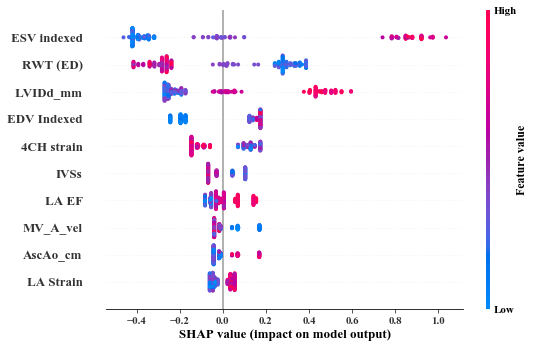

{'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.4, 'gamma': 0.4, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 13, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 9, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'alpha': 9}


In [8]:
# Model creation and evaluation
[y_pred, yMS_MM_SM_pred, importances, shap_ex] = create_model(best_parameters, 
                                                   normalized_train.iloc[:,1:], new_y,
                                                   normalized_test.iloc[:,1:], new_ytest, 
                                                   normalized_MS_MM_SM.iloc[:,2:])

new_yassign = list()
new_yassign = numpy.concatenate((normalized_train.iloc[:,0], yMS_MM_SM_pred))

In [9]:
n_splits = 5
kf = KFold(n_splits = n_splits, shuffle = True, random_state = None)

robust = XGBClassifier(n_estimators = best_parameters['n_estimators'],
                       max_depth = best_parameters['max_depth'],
                       min_child_weight = best_parameters['min_child_weight'],
                       learning_rate = best_parameters['learning_rate'],
                       gamma = best_parameters['gamma'],
                       colsample_bytree = best_parameters['colsample_bytree'],
                       alpha = best_parameters['alpha'])

In [10]:
#Renormalize all the data 
normalized_train=pandas.DataFrame(scaler.fit_transform(SAS_SAR_MAS_MAR.iloc[:,1:]))
normalized_train.columns = x_features_to_train
normalized_train.insert(0, 'Group', ySAS_SAR_MAS_MAR)
new_y = normalized_train.iloc[:,0].mod(2)

inputdata = normalized_train.iloc[:,1:]
inputdata.columns = Display_columns_train

features = list()
index_test = list()
prob_MS_MM_SM_pred = list()

shap_content = []
test_pred_content =[]
k_fold = 5
expected_value=list()

for k in range(k_fold):
    prob_test_dict = {}
    
    for train_index, test_index in kf.split(inputdata):
        
        shap_dict = {}
        Y_train = list()
        X_train = list()
        Y_test = list()
        X_test = list()
        
        for i in train_index:
            Y_train.append(new_y[i])
            X_train.append(inputdata.iloc[i,:])
            
        for i in test_index:
            Y_test.append(new_y[i])
            X_test.append(inputdata.iloc[i,:])
                
                
        robust.fit(numpy.array(X_train), numpy.array(Y_train))
        print(metrics.classification_report(Y_test, robust.predict(numpy.array(X_test))))
            
        prob_test = robust.predict_proba(numpy.array(X_test))
        prob_MS_MM_SM_tmp = robust.predict_proba(numpy.array(normalized_MS_MM_SM.iloc[:,2:]))
        prob_MS_MM_SM_pred.append(prob_MS_MM_SM_tmp[:,1])
        index_test.append(test_index)
            
        # save the probablity of class AS for test data
        for i in range(0,len(test_index)):
            prob_test_dict[test_index[i]] = prob_test[:,1][i]
#         print(prob_test_dict)
            
        #shapvalues
        mybooster = robust.get_booster()
        model_bytearray = mybooster.save_raw()[4:]
        def myfun(self=None):
            return model_bytearray
        mybooster.save_raw = myfun

        # Shap explainer initilization
        explainer=shap.TreeExplainer(mybooster)
        shap_ex = explainer.shap_values(numpy.array(X_train))
        shap_ex = pandas.DataFrame(shap_ex)
#         print(explainer.expected_value)
#         print(shap_ex)
#         shap.initjs()
        expected_value.append(explainer.expected_value)
        shap_ex.index = train_index
        for i in train_index:
            shap_dict[int(i)] = numpy.array(shap_ex.loc[int(i),:])
        for i in test_index:
            shap_dict[int(i)] = numpy.zeros(len(inputdata.columns))

        shap_content.append(shap_dict)
        features.append(robust.feature_importances_)
    
    test_pred_content.append(prob_test_dict)

              precision    recall  f1-score   support

           0       0.91      0.97      0.94        31
           1       0.93      0.82      0.87        17

    accuracy                           0.92        48
   macro avg       0.92      0.90      0.91        48
weighted avg       0.92      0.92      0.92        48

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        29
           1       1.00      0.89      0.94        19

    accuracy                           0.96        48
   macro avg       0.97      0.95      0.96        48
weighted avg       0.96      0.96      0.96        48

              precision    recall  f1-score   support

           0       0.91      0.84      0.87        25
           1       0.84      0.91      0.87        23

    accuracy                           0.88        48
   macro avg       0.88      0.88      0.87        48
weighted avg       0.88      0.88      0.87        48

              preci

AUC: 0.9396088545024716
          tf  threshold       fpr       tpr
26  0.003439    0.37656  0.134752  0.868687
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       136
           1       0.86      0.82      0.84       104

    accuracy                           0.86       240
   macro avg       0.86      0.86      0.86       240
weighted avg       0.86      0.86      0.86       240



`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


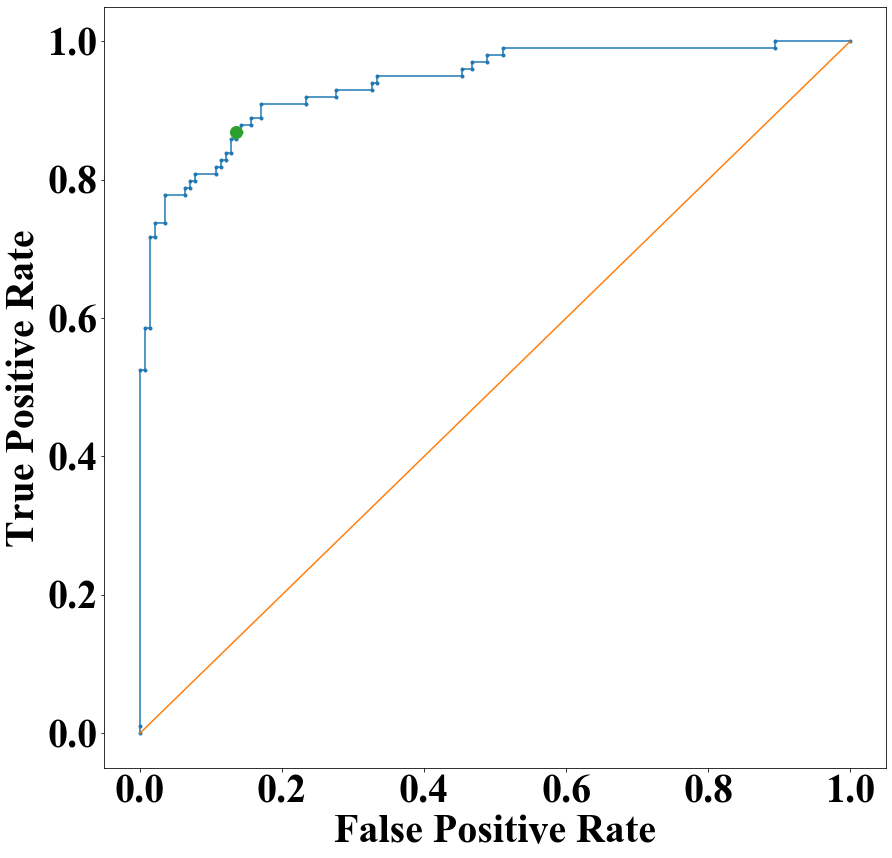

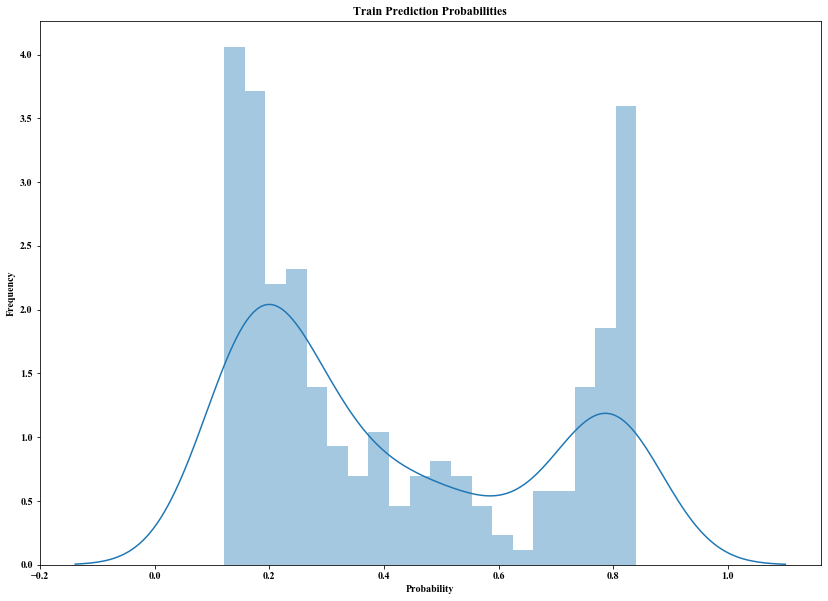

In [11]:
predprob=list()
for i in range(0,len(inputdata)):
    avgpredsum = 0
    for k in range(k_fold):
        avgpredsum += test_pred_content[k][i]
    avgpredsum /= k_fold
    
    predprob.append(avgpredsum)
    
fpr, tpr, thresholds = roc_curve(new_y, predprob)

xgboost_auc = roc_auc_score(new_y,predprob)
print('AUC:',xgboost_auc)

x_chance=numpy.linspace(0,1,40)
y_chance=x_chance

fxn_threshold= Find_Optimal_Cutoff(new_y, predprob)
print(fxn_threshold)

plt.figure(figsize =  (14, 14))
plt.plot(fpr,tpr, marker='.')
plt.plot(x_chance,y_chance)
plt.xlabel('False Positive Rate', fontsize=40)
plt.ylabel('True Positive Rate', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.plot(fxn_threshold['fpr'],fxn_threshold['tpr'],marker='.', markersize=24)
plt.savefig('ROCplot.pdf', bbox_inches = 'tight', dpi = 300)

threshold=list(fxn_threshold['threshold'])

totalpred=list()
for i in predprob:
    if i > threshold:
        totalpred.append(1)
    else:
        totalpred.append(0)
        
print(metrics.classification_report(totalpred, new_y))

plt.figure(figsize = (14, 10))
sns.distplot(predprob,bins=20)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Train Prediction Probabilities')
histogram=numpy.histogram(predprob,bins=24)

No handles with labels found to put in legend.


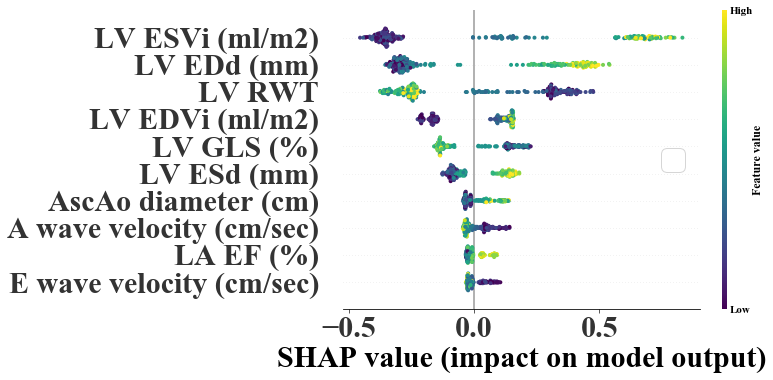

In [12]:
# Define colormap
my_cmap = plt.get_cmap('viridis')

# Average shap value table            
avgshap = pandas.DataFrame()

for i in range(0,len(shap_content[0])):
    for j in range (0,len(shap_content[0][0])):
        avgvalue = 0
        for k in range (0,len(shap_content)):
            avgvalue += shap_content[k][i][j]
        avgvalue /= k_fold * (n_splits - 1)
        avgshap.at[int(i), int(j)] = avgvalue
        
plt.figure(figsize = (14, 10))
shap.summary_plot(numpy.array(avgshap), inputdata, plot_type = "dot", show = False, max_display=10)
plt.gca().xaxis.label.set_size(30)
plt.gca().yaxis.label.set_size(30)
plt.gca().tick_params(labelsize = 30)
plt.legend(prop = {"size": 30})

# Change the colormap of the artists
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_cmap)
            
plt.savefig('Shap_average.pdf', bbox_inches = 'tight', dpi = 300)

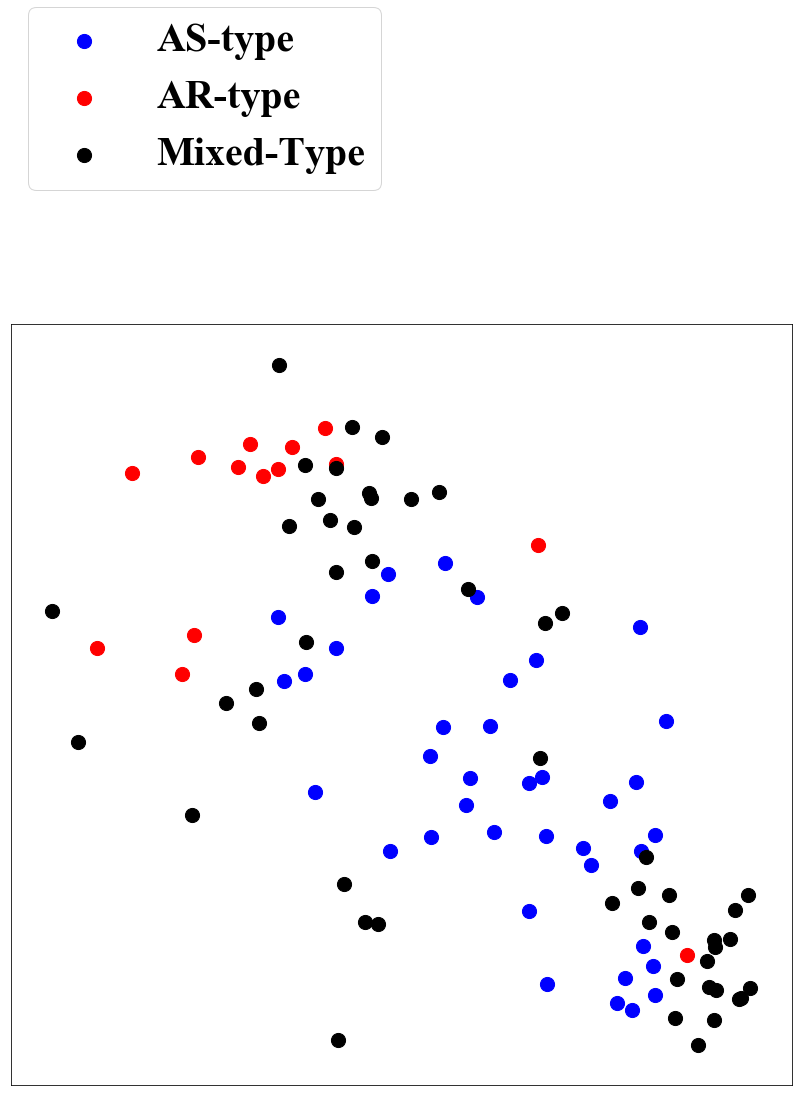

In [13]:
prob_MS_MM_SM_new=pandas.DataFrame(prob_MS_MM_SM_pred)
prob_MS_MM_SM_new=prob_MS_MM_SM_new.transpose() 

mixed_test=train_test_split(prob_MS_MM_SM_new.mean(axis=1), shuffle=True, test_size=0.1, random_state=42)[1]
mixed_train=train_test_split(prob_MS_MM_SM_new.mean(axis=1), shuffle=True, test_size=0.1, random_state=42)[0]

threshold1=0.33
threshold2=0.66

MS_MM_SM_newlabel=list()
for i in prob_MS_MM_SM_new.mean(axis=1):
    if i > threshold2:
        MS_MM_SM_newlabel.append(1)
    if i < threshold1:
        MS_MM_SM_newlabel.append(3)
    if i >= threshold1 and i <= threshold2:
        MS_MM_SM_newlabel.append(2)

tmp = tsne_df
tsne_df = tsne_df.iloc[train_length:,:]


tsne_plot([3,1,2], numpy.asarray(MS_MM_SM_newlabel),['blue','red','black'],['AS-type','AR-type','Mixed-Type'])

In [14]:

# Statistical analysis

means = list()
std = list()

validated_dict={}
for i in range(0,len(normalized_MS_MM_SM)):
    validated_dict[str(normalized_MS_MM_SM.iloc[i,0])]=MS_MM_SM_newlabel[i]
    
x1=raw_data[['Group']+['Study_No']]
x2=raw_data[all_columns_raw]
xall=numpy.concatenate((x1,x2),axis=1)
xall=pandas.DataFrame(xall)
[MS, MM, SM, SAS, SAR, MAS, MAR] = separate_groups(xall)

yMS_MM_SM = pandas.DataFrame(numpy.concatenate((yMS, yMM, ySM)))
MS_MM_SM = pandas.DataFrame(numpy.concatenate((MS, MM, SM)))

MS_MM_SM.insert(1, 'True Group', yMS_MM_SM)

prediction_order=list()
for i in range(0,len(MS_MM_SM)):
    prediction_order.append(validated_dict.get(str(MS_MM_SM.iloc[i,0])))
    
MS_MM_SM.insert(2, 'New Group', prediction_order)

xtrainingAS = pandas.DataFrame(numpy.concatenate((SAS, MAS)))
xtrainingAR = pandas.DataFrame(numpy.concatenate((SAR, MAR)))

xtrainingAS=xtrainingAS.iloc[:,1:].astype(float)
xtrainingAR=xtrainingAR.iloc[:,1:].astype(float)

AS_new = list()
AR_new = list()
Indeterminant=list()
for i in MS_MM_SM.values.tolist():
    if i[2] == 3:
        AS_new.append(i[3:])
    if i[2] == 1:
        AR_new.append(i[3:])
    if i[2] ==2:
        Indeterminant.append(i[3:])

AS_new=numpy.array(AS_new).astype(numpy.float)
AR_new=numpy.array(AR_new).astype(numpy.float)
Indeterminant=numpy.array(Indeterminant).astype(numpy.float)

differences = stats.ttest_ind(AS_new, AR_new)
differences = differences[1]
differences = pandas.DataFrame(differences)
differences = differences.transpose()

diff_ASInd = pandas.DataFrame(stats.ttest_ind(AS_new, Indeterminant)[1]).transpose()
diff_ARInd = pandas.DataFrame(stats.ttest_ind(AR_new, Indeterminant)[1]).transpose()

F, p = f_oneway(AR_new, AS_new, Indeterminant)
p=pandas.DataFrame(p)
p=p.transpose()

AS_new = pandas.DataFrame(AS_new)
meanAS_new = AS_new.mean(axis = 0)
stdAS_new=AS_new.std(axis=0)

AR_new = pandas.DataFrame(AR_new)
meanAR_new = AR_new.mean(axis = 0)
stdAR_new=AR_new.std(axis=0)

Indeterminant=pandas.DataFrame(Indeterminant)
mean_Indeterminant=Indeterminant.mean(axis=0)
std_Indeterminant=Indeterminant.std(axis=0)

comparison = pandas.DataFrame()

for x in range(0,len(meanAS_new)):
    comparison.at[0,x] = meanAS_new[x]
    comparison.at[1,x] = meanAR_new[x]
    comparison.at[2,x] = mean_Indeterminant[x]
    comparison.at[3,x] = differences.iloc[0,x]
    comparison.at[4,x]= p.iloc[0,x]
    comparison.at[5,x]= diff_ASInd.iloc[0,x]
    comparison.at[6,x]= diff_ARInd.iloc[0,x]

comparison.index = ['AS-type','AR-type','Mixed-type','AS vs. AR p-value','anova', 'AS vs. Mixed p-value',
                   'AR vs. Mixed p-value']
comparison.columns=Display_columns_all



# print(comparison)

MS = pandas.DataFrame(MS)
MS_means=MS.mean(axis=0)
MS_means=MS_means.reset_index(drop = True)
MS_std=MS.std(axis=0)
MS_std=MS_std.reset_index(drop = True)

MM = pandas.DataFrame(MM)
MM_means=MM.mean(axis=0)
MM_means=MM_means.reset_index(drop = True)
MM_std=MM.std(axis=0)
MM_std=MM_std.reset_index(drop = True)

SM = pandas.DataFrame(SM)
SM_means=SM.mean(axis=0)
SM_means=SM_means.reset_index(drop = True)
SM_std=SM.std(axis=0)
SM_std=SM_std.reset_index(drop = True)

SAS = pandas.DataFrame(SAS)
SAS_means=SAS.mean(axis=0)
SAS_means=SAS_means.reset_index(drop = True)
SAS_std=SAS.std(axis=0)
SAS_std=SAS_std.reset_index(drop = True)

SAR = pandas.DataFrame(SAR)
SAR_means=SAR.mean(axis=0)
SAR_means=SAR_means.reset_index(drop = True)
SAR_std=SAR.std(axis=0)
SAR_std=SAR_std.reset_index(drop = True)

MAS = pandas.DataFrame(MAS)
MAS_means=MAS.mean(axis=0)
MAS_means=MAS_means.reset_index(drop = True)
MAS_std=MAS.std(axis=0)
MAS_std=MAS_std.reset_index(drop = True)

MAR = pandas.DataFrame(MAR)
MAR_means=MAR.mean(axis=0)
MAR_means=MAR_means.reset_index(drop = True)
MAR_std=MAR.std(axis=0)
MAR_std=MAR_std.reset_index(drop = True)

xtrainingAS = pandas.DataFrame(xtrainingAS)
xtrainingAS_means=xtrainingAS.mean(axis=0)
xtrainingAS_means=xtrainingAS_means.reset_index(drop = True)
xtrainingAS_std=xtrainingAS.std(axis=0)
xtrainingAS_std=xtrainingAS_std.reset_index(drop = True)

xtrainingAR = pandas.DataFrame(xtrainingAR)
xtrainingAR_means=xtrainingAR.mean(axis=0)
xtrainingAR_means=xtrainingAR_means.reset_index(drop = True)
xtrainingAR_std=xtrainingAR.std(axis=0)
xtrainingAR_std=xtrainingAR_std.reset_index(drop = True)

means.append(MS_means)
means.append(MM_means)
means.append(SM_means)
means.append(SAS_means)
means.append(SAR_means)
means.append(MAS_means)
means.append(MAR_means)        
means.append(meanAS_new)
means.append(meanAR_new)
means.append(mean_Indeterminant)
means.append(xtrainingAS_means)
means.append(xtrainingAR_means)
means = pandas.DataFrame(means)
means.columns = Display_columns_all
means.index = ['MS', 'MM', 'SM', 'S-AS', 'S-AR', 'M-AS', 'M-AR','AS-type','AR-type','Mixed' ,'mod + AS','mod + AR']
means = means.fillna(0)


std.append(MS_std)
std.append(MM_std)
std.append(SM_std)
std.append(SAS_std)
std.append(SAR_std)
std.append(MAS_std)
std.append(MAR_std)        
std.append(stdAS_new)
std.append(stdAR_new)
std.append(std_Indeterminant)
std.append(xtrainingAS_std)
std.append(xtrainingAR_std)
std = pandas.DataFrame(std)
std.columns = Display_columns_all
std.index = ['MS', 'MM', 'SM', 'S-AS', 'S-AR', 'M-AS', 'M-AR', 'AS-type', 'AR-type','Mixed', 'mod + AS', 'mod + AR']
std = std.fillna(0)
# print(std)

freq=list()
for i in range(0, len(MS_MM_SM)):
    if MS_MM_SM.loc[i,'True Group']==1:
        if MS_MM_SM.loc[i,'New Group']==0:
            freq.append(0)
        if MS_MM_SM.loc[i,'New Group']==1:
            freq.append(1)
        if MS_MM_SM.loc[i,'New Group']==2:
            freq.append(2)
    if MS_MM_SM.loc[i,'True Group']==2:
        if MS_MM_SM.loc[i,'New Group']==0:
            freq.append(3)
        if MS_MM_SM.loc[i,'New Group']==1:
            freq.append(4)
        if MS_MM_SM.loc[i,'New Group']==2:
            freq.append(5)
    if MS_MM_SM.loc[i,'True Group']==3:
        if MS_MM_SM.loc[i,'New Group']==0:
            freq.append(6)
        if MS_MM_SM.loc[i,'New Group']==1:
            freq.append(7)
        if MS_MM_SM.loc[i,'New Group']==2:
            freq.append(8)
            
frq_table=pandas.DataFrame([[freq.count(0),freq.count(2),freq.count(1)],
                           [freq.count(3),freq.count(5),freq.count(4)],
                           [freq.count(6),freq.count(8),freq.count(7)]],
                          columns=['AS-type','Mixed-type','AR-type'],
                          index=['Mod AS- Sev AR','Mod AS- Mod AR','Sev AS- Mod AR'])


In [15]:
#integrating symptoms
symptoms_data=pandas.read_excel('/Users/Rashmi/Desktop/July7Symptoms.xlsx')
AVR=symptoms_data['Referral_AVR']
StudyID=symptoms_data['Study_No']
unique=list()
identifier=['Study_No','Group']
uniqueid=raw_data[identifier]
for i in uniqueid.values.tolist():
    if i[1]==1:
        unique.append(i[0:])
    if i[1]==2:
        unique.append(i[0:])
    if i[1]==3:
        unique.append(i[0:])

unique=pandas.DataFrame(unique)
unique.sort_values(by=[1],inplace=True)

class_values_dict={}
for i in unique.values.tolist():
    class_values_dict[str(i[0])]=i[1]

classification=['New Group', 'True Group', 0]
classid=MS_MM_SM[classification]

for i in range(0,len(classid)):
    classid.at[i,3]=class_values_dict.get(str(classid.iloc[i,2]))
    

#     for i in classid.values.tolist():
#         if i[1] != i[3]:
#             print(i[2])

symptoms_dict={}
for i in symptoms_data.values.tolist():
        symptoms_dict[str(i[0])]=i[3:]
        
for i in range(0,len(classid)):
    symp=symptoms_dict.get(str(classid.iloc[i,2]))
    if symp[1] > 0: 
        classid.at[i,4]=1
    else: 
        classid.at[i,4]=0
    if symp[2] > 0:
        classid.at[i,5]=1
    else: 
        classid.at[i,5]=0
    if symp[3] > 0:
        classid.at[i,6]=1
    else: 
        classid.at[i,6]=0
    if symp[6] > 0:
        classid.at[i,7]=1
    else:
        classid.at[i,7]=0
    if (symp[1]+symp[2]+symp[3]) > 0:
        classid.at[i,8]=1
    else:
        classid.at[i,8]=0
    if classid.at[i,8]>0 or symp[6]>0:
        classid.at[i,9]=1
    else:
        classid.at[i,9]=0
        

print(classid)
        
MSAS=list()
MSAR=list()
MSInd=list()
MMAS=list()
MMAR=list()
MMInd=list()
SMAS=list()
SMAR=list()
SMInd=list()
for i in range(0,len(classid)):
    if classid.iloc[i,1]==1:
        if classid.iloc[i,0]==0:
            MSAS.append(classid.iloc[i,4:])
        if classid.iloc[i,0]==1:
            MSAR.append(classid.iloc[i,4:]) 
        if classid.iloc[i,0]==2:
            MSInd.append(classid.iloc[i,4:])       
    if classid.iloc[i,1]==2:
        if classid.iloc[i,0]==0:
            MMAS.append(classid.iloc[i,4:])
        if classid.iloc[i,0]==1:
            MMAR.append(classid.iloc[i,4:])
        if classid.iloc[i,0]==2:
            MMInd.append(classid.iloc[i,4:])
    if classid.iloc[i,1]==3:
        if classid.iloc[i,0]==0:
            SMAS.append(classid.iloc[i,4:])
        if classid.iloc[i,0]==1:
            SMAR.append(classid.iloc[i,4:])
        if classid.iloc[i,0]==2:
            SMInd.append(classid.iloc[i,4:])
            
counter1=len(MSAS)
counter2=len(MSAR)
counter3=len(MMAS)
counter4=len(MMAR)
counter5=len(SMAS)
counter6=len(SMAR)
counter7=len(MSInd)
counter8=len(MMInd)
counter9=len(SMInd)

MSAS=pandas.DataFrame(MSAS)
MSAR=pandas.DataFrame(MSAR)
MSInd=pandas.DataFrame(MSInd)
MMAS=pandas.DataFrame(MMAS)
MMAR=pandas.DataFrame(MMAR)
MMInd=pandas.DataFrame(MMInd)
SMAS=pandas.DataFrame(SMAS)
SMAR=pandas.DataFrame(SMAR)
SMInd=pandas.DataFrame(SMInd)

MSAS_sum=my_sum(MSAS)
MSAR_sum=my_sum(MSAR)
MSInd_sum=my_sum(MSInd)
MMAS_sum=my_sum(MMAS)
MMAR_sum=my_sum(MMAR)
MMInd_sum=my_sum(MMInd)
SMAS_sum=my_sum(SMAS)
SMAR_sum=my_sum(SMAR)
SMInd_sum=my_sum(SMInd)

all_symptoms=pandas.DataFrame()
for n in range(0, len(MMAS_sum)):
    all_symptoms.at[0,n]= MSAS_sum[n]
    all_symptoms.at[1,n]= MSAR_sum[n]
    all_symptoms.at[2,n]= MSInd_sum[n]
    all_symptoms.at[3,n]= MMAS_sum[n]
    all_symptoms.at[4,n]= MMAR_sum[n]
    all_symptoms.at[5,n]= MMInd_sum[n]
    all_symptoms.at[6,n]= SMAS_sum[n]
    all_symptoms.at[7,n]= SMAR_sum[n]
    all_symptoms.at[8,n]= SMInd_sum[n]
    all_symptoms.at[9,n]= MSAS_sum[n]+MMAS_sum[n]+SMAS_sum[n]
    all_symptoms.at[10,n]=MSAR_sum[n]+MMAR_sum[n]+SMAR_sum[n]
    all_symptoms.at[11,n]=MSInd_sum[n]+MMInd_sum[n]+SMInd_sum[n]
values=['Dyspnea','Syncope','Angina','AVR','All symptoms','All Symptoms OR AVR']
all_symptoms.columns=values
all_symptoms.index=['MS-AS','MS-AR','MS-Mixed','MM-AS', 'MM-AR', 'MM-Mixed','SM-AS', 'SM-AR', 'SM-Mixed','AS-type',
                   'AR-type','Mixed-Type']
all_sympperc=list()

all_sympperc.append(all_symptoms.iloc[0,:]/len(MSAS))
all_sympperc.append(all_symptoms.iloc[1,:]/len(MSAR))
all_sympperc.append(all_symptoms.iloc[2,:]/len(MSInd))
all_sympperc.append(all_symptoms.iloc[3,:]/len(MMAS))
all_sympperc.append(all_symptoms.iloc[4,:]/len(MMAR))
all_sympperc.append(all_symptoms.iloc[5,:]/len(MMInd))
all_sympperc.append(all_symptoms.iloc[6,:]/len(SMAS))
all_sympperc.append(all_symptoms.iloc[7,:]/len(SMAR))
all_sympperc.append(all_symptoms.iloc[8,:]/len(SMInd))
all_sympperc.append(all_symptoms.iloc[9,:]/(len(MSAS)+len(MMAS)+len(SMAS)))
all_sympperc.append(all_symptoms.iloc[10,:]/(len(MSAR)+len(MMAR)+len(SMAR)))
all_sympperc.append(all_symptoms.iloc[11,:]/(len(MSInd)+len(MMInd)+len(SMInd)))
all_sympperc=pandas.DataFrame(all_sympperc)
all_sympperc=all_sympperc*100

# print(all_sympperc)

     New Group  True Group        0    3    4    5    6    7    8    9
0            2           1   M-S-10  1.0  1.0  1.0  1.0  1.0  1.0  1.0
1            1           1  MS -S-1  1.0  0.0  0.0  0.0  0.0  0.0  0.0
2            1           1  MS-SR-7  1.0  0.0  0.0  0.0  0.0  0.0  0.0
3            2           1    SAR-3  1.0  0.0  0.0  0.0  0.0  0.0  0.0
4            2           1   SAR-18  1.0  0.0  0.0  0.0  0.0  0.0  0.0
..         ...         ...      ...  ...  ...  ...  ...  ...  ...  ...
98           3           3   S-MS-3  3.0  0.0  0.0  0.0  0.0  0.0  0.0
99           3           3   S-MS-4  3.0  0.0  1.0  1.0  1.0  1.0  1.0
100          3           3   S-MS-6  3.0  1.0  0.0  0.0  1.0  1.0  1.0
101          1           3    S-S-6  3.0  1.0  0.0  0.0  1.0  1.0  1.0
102          1           3    S-S-7  3.0  0.0  0.0  1.0  1.0  1.0  1.0

[103 rows x 10 columns]



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
AS_like_group = numpy.concatenate((MSAS, MMAS, SMAS)) if MSAS.size else numpy.concatenate((MMAS,SMAS))
AR_like_group = numpy.concatenate((MSAR, MMAR, SMAR))
Indeterminant_group=numpy.concatenate((MSInd,MMInd,SMInd)) if MSInd.size else numpy.concatenate((MMInd,SMInd))

chip_values=list()

for i in range(0,6):
    print('==============', values[i],'==============')
    categorize(AS_like_group,AR_like_group,i, 'AS_like', 'AR_like')
    
    print('==============', values[i],'==============')
    categorize(AS_like_group,Indeterminant_group,i, 'AS_like', 'Indeterminant')
    
    print('==============', values[i],'==============')
    categorize(AR_like_group,Indeterminant_group,i, 'AR_like', 'Indeterminant')

============== Dyspnea ==============


IndexError: index 0 is out of bounds for axis 1 with size 0

In [19]:
chi_results=list()
chip_values=list()

chi_results.append(chip_values[0:3])
chi_results.append(chip_values[3:6])
chi_results.append(chip_values[6:9])
chi_results.append(chip_values[9:12])
chi_results.append(chip_values[12:15])
chi_results.append(chip_values[15:18])

chi_results=pandas.DataFrame(chi_results).transpose()
chi_results.columns=all_symptoms.columns
# chi_results.index=['AS-type vs. AR-type', 'AS-type vs. Mixed-type', 'AR-type vs. Mixed- Type']
symptoms_results=pandas.DataFrame(numpy.concatenate((all_sympperc.iloc[9:,:],chi_results)))
symptoms_results.columns=all_symptoms.columns
symptoms_results.index=numpy.concatenate((all_sympperc.iloc[9:,:].index,chi_results.index))
print(symptoms_results)

              Dyspnea    Syncope    Angina        AVR  All symptoms  \
AS-type     15.384615  10.256410  5.128205  51.282051     17.948718   
AR-type      0.000000   0.000000  0.000000  30.769231      0.000000   
Mixed-Type  11.764706   5.882353  5.882353  70.588235     15.686275   

            All Symptoms OR AVR  
AS-type               51.282051  
AR-type               30.769231  
Mixed-Type            76.470588  


In [19]:
#  normalized_train.iloc[:,1:], new_y,
#                                                    normalized_test.iloc[:,1:], new_ytest, 
#                                                    normalized_MS_MM_SM.iloc[:,2:]

In [20]:
def log_reg(features,labels,testfeatures,testlabel):
    logisticRegr = LogisticRegression()
    logisticRegr.fit(features,labels)
    y_pred=logisticRegr.predict(testfeatures)
    y_pred_prob=logisticRegr.predict_proba(testfeatures)
    coeff=logisticRegr.coef_
    print(metrics.classification_report(testlabel, y_pred))
    print('AUC:',roc_auc_score(testlabel, y_pred))
    return y_pred,y_pred_prob,coeff

In [21]:
[a,b,c]=log_reg(normalized_train.iloc[:,1:],new_y,normalized_test.iloc[:,1:],new_ytest)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        30
           1       0.89      0.89      0.89        18

    accuracy                           0.92        48
   macro avg       0.91      0.91      0.91        48
weighted avg       0.92      0.92      0.92        48

AUC: 0.9111111111111111


In [22]:
counter1=len(MSAS)
counter2=len(MSAR)
counter3=len(MMAS)
counter4=len(MMAR)
counter5=len(SMAS)
counter6=len(SMAR)
counter7=len(MSInd)
counter8=len(MMInd)
counter9=len(SMInd)

In [23]:
print('MSAS',counter1)
print('MSAR',counter2)
print('MMAS',counter3)
print('MMAR',counter4)
print('SMAS',counter5)
print('SMAR',counter6)
print('MSInd',counter7)
print('MMInd',counter8)
print('SMInd',counter9)

MSAS 0
MSAR 4
MMAS 17
MMAR 5
SMAS 21
SMAR 2
MSInd 3
MMInd 18
SMInd 33


In [42]:
comparison_writer=pandas.ExcelWriter('symptomsforwendy.xlsx')
classid.to_excel(comparison_writer)
comparison_writer.save()

In [ ]:
# MS = pandas.DataFrame(MS)
# MS_means=MS.mean(axis=0)
# MS_means=MS_means.reset_index(drop = True)
# MS_std=MS.std(axis=0)
# MS_std=MS_std.reset_index(drop = True)

# MM = pandas.DataFrame(MM)
# MM_means=MM.mean(axis=0)
# MM_means=MM_means.reset_index(drop = True)
# MM_std=MM.std(axis=0)
# MM_std=MM_std.reset_index(drop = True)

# SM = pandas.DataFrame(SM)
# SM_means=SM.mean(axis=0)
# SM_means=SM_means.reset_index(drop = True)
# SM_std=SM.std(axis=0)
# SM_std=SM_std.reset_index(drop = True)

# SAS = pandas.DataFrame(SAS)
# SAS_means=SAS.mean(axis=0)
# SAS_means=SAS_means.reset_index(drop = True)
# SAS_std=SAS.std(axis=0)
# SAS_std=SAS_std.reset_index(drop = True)

# SAR = pandas.DataFrame(SAR)
# SAR_means=SAR.mean(axis=0)
# SAR_means=SAR_means.reset_index(drop = True)
# SAR_std=SAR.std(axis=0)
# SAR_std=SAR_std.reset_index(drop = True)

# MAS = pandas.DataFrame(MAS)
# MAS_means=MAS.mean(axis=0)
# MAS_means=MAS_means.reset_index(drop = True)
# MAS_std=MAS.std(axis=0)
# MAS_std=MAS_std.reset_index(drop = True)

# MAR = pandas.DataFrame(MAR)
# MAR_means=MAR.mean(axis=0)
# MAR_means=MAR_means.reset_index(drop = True)
# MAR_std=MAR.std(axis=0)
# MAR_std=MAR_std.reset_index(drop = True)

# xtrainingAS = pandas.DataFrame(xtrainingAS)
# xtrainingAS_means=xtrainingAS.mean(axis=0)
# xtrainingAS_means=xtrainingAS_means.reset_index(drop = True)
# xtrainingAS_std=xtrainingAS.std(axis=0)
# xtrainingAS_std=xtrainingAS_std.reset_index(drop = True)

# xtrainingAR = pandas.DataFrame(xtrainingAR)
# xtrainingAR_means=xtrainingAR.mean(axis=0)
# xtrainingAR_means=xtrainingAR_means.reset_index(drop = True)
# xtrainingAR_std=xtrainingAR.std(axis=0)
# xtrainingAR_std=xtrainingAR_std.reset_index(drop = True)

# means.append(MS_means)
# means.append(MM_means)
# means.append(SM_means)
# means.append(SAS_means)
# means.append(SAR_means)
# means.append(MAS_means)
# means.append(MAR_means)        
# means.append(meanAS_new)
# means.append(meanAR_new)
# means.append(mean_Indeterminant)
# means.append(xtrainingAS_means)
# means.append(xtrainingAR_means)
# means = pandas.DataFrame(means)
# means.columns = Display_columns_all
# means.index = ['MS', 'MM', 'SM', 'S-AS', 'S-AR', 'M-AS', 'M-AR','AS-type','AR-type','Mixed' ,'mod + AS','mod + AR']
# means = means.fillna(0)

In [16]:
parameters=['Label','True Group','New Group']
columntitles=numpy.concatenate((parameters,Display_columns_all))
MS_MM_SM.columns=columntitles

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
0,M-S-10,3.800000,67.000000,114.000000,136.333333,0.868865,0.404318,0.307018,2.0,64.0,...,3.0,2.1,3.5,243.000000,50.0,36.0,13.0,11.0,18.0,14.0
1,MS -S-1,3.833333,34.333333,59.333333,94.333333,1.287720,0.637343,0.465652,2.0,31.0,...,2.7,2.0,3.6,182.333333,61.0,38.0,11.0,10.0,14.0,14.0
2,MS-SR-7,3.733333,83.000000,56.000000,83.000000,1.599184,0.934608,0.267857,1.0,22.0,...,3.5,2.6,3.8,161.000000,60.0,49.0,9.0,9.0,12.0,12.0
3,SAR-3,2.800000,16.000000,31.666667,64.333333,1.812561,1.106281,0.523810,1.0,52.0,...,3.0,2.1,3.2,183.666667,53.0,35.0,10.0,7.0,12.0,9.0
4,SAR-18,3.566667,27.333333,51.666667,88.000000,1.765004,0.821327,0.336449,2.0,64.0,...,3.1,2.4,3.2,180.666667,57.0,34.0,10.0,8.0,14.0,11.0
5,SAR-19,3.700000,32.000000,54.000000,65.000000,2.858849,1.258233,0.486486,2.0,20.0,...,4.0,2.6,4.6,168.000000,61.0,49.0,12.0,8.0,15.0,11.0
6,SAR-35,3.000000,21.000000,34.000000,65.000000,2.090000,1.220000,0.500000,2.0,25.0,...,3.4,2.4,3.5,167.000000,59.0,42.0,8.0,8.0,12.0,12.0


In [88]:
comparison_writer=pandas.ExcelWriter('analyticsJan31.xlsx')
MS_MM_SM.to_excel(comparison_writer)
comparison_writer.save()

In [50]:
Group3=MS_MM_SM[MS_MM_SM["True Group"]==3]

differences = stats.ttest_ind(numpy.array(Group3[Group3["New Group"]==3].iloc[:,3:]).astype(numpy.float),
                              numpy.array(Group3[Group3["New Group"]==2].iloc[:,3:]).astype(numpy.float))
differences = differences[1]
differences = pandas.DataFrame(differences)
differences = differences.transpose()
differences.columns=Group3.columns[3:]
print(differences.iloc[0,28:38])

LA Strain (%)                           7.551606e-02
Contractile Strain (%)                  7.034800e-02
Conduit Strain (%)                      1.373804e-01
LA (Corrected Time to Peak) %           5.732751e-01
LV (Corrected Time to Peak) %           5.539683e-01
End Diastolic Volume(ml)                1.644294e-07
End Diastolic Volume Indexed (ml/m2)    3.320500e-09
End Systolic Volume(ml)                 4.132755e-08
End Systolic Volume Indexed (ml/m2)     1.736179e-09
Cardiac Output (L/min)                  9.467124e-01
Name: 0, dtype: float64


In [115]:
Group2=MS_MM_SM[MS_MM_SM["True Group"]==2]

differences = stats.ttest_ind(numpy.array(Group2[Group2["New Group"]==2].iloc[:,3:]).astype(numpy.float),
                              numpy.array(Group2[Group2["New Group"]==1].iloc[:,3:]).astype(numpy.float))
differences = differences[1]
differences = pandas.DataFrame(differences)
differences = differences.transpose()
differences.columns=Group2.columns[3:]
print(differences.iloc[0,0:18])

Vmax(m/s)                                    0.521092
Mean gradient (mmHg)                         0.587508
Peak gradient (mmHg)                         0.461665
Velocity time integral (m)                   0.434432
Aortic valve area (cm2)                      0.097986
Indexed Aortic valve area (cm2/m2)           0.424249
Dimensionless Velocity Ratio                 0.263024
AR Jet Grade                                 0.431612
Age                                          0.401043
Gender                                       0.038603
BSA                                          0.023821
Vena contracta (cm)                          0.067678
AR jet width (cm)                            0.123709
AR width LVOT (cm)                           0.095299
AR jet LVOT ratio                            0.414695
AR Pressure Half Time (s)                    0.481080
AR End Systolic Pressure (mmHg)              0.355140
AR End Diastolic Pressure Gradient (mmHg)    0.797209
Name: 0, dtype: float64


In [81]:
Group2=MS_MM_SM[MS_MM_SM["New Group"]==2]

differences = stats.ttest_ind(numpy.array(Group2[Group2["True Group"]==1].iloc[:,3:]).astype(numpy.float),
                              numpy.array(Group2[Group2["True Group"]==3].iloc[:,3:]).astype(numpy.float))
differences = differences[1]
differences = pandas.DataFrame(differences)
differences = differences.transpose()
differences.columns=Group2.columns[3:]
print(differences.iloc[0,:])

Vmax(m/s)                                    0.000799
Mean gradient (mmHg)                         0.052710
Peak gradient (mmHg)                         0.096098
Velocity time integral (m)                   0.130626
Aortic valve area (cm2)                      0.002506
Indexed Aortic valve area (cm2/m2)           0.003548
Dimensionless Velocity Ratio                 0.000018
AR Jet Grade                                 0.218025
Age                                          0.986957
Gender                                       0.736756
BSA                                          0.366719
Vena contracta (cm)                          0.374015
AR jet width (cm)                            0.301636
AR width LVOT (cm)                           0.930022
AR jet LVOT ratio                            0.298922
AR Pressure Half Time (s)                    0.555356
AR End Systolic Pressure (mmHg)              0.941706
AR End Diastolic Pressure Gradient (mmHg)    0.160831
E velocity (cm/sec)         

,Vmax(m/s),Mean gradient (mmHg),Peak gradient (mmHg),Velocity time integral (m),Aortic valve area (cm2),Indexed Aortic valve area (cm2/m2),Dimensionless Velocity Ratio,AR Jet Grade,Age,Gender,...,Aortic sinus (cm),LVOT (cm),AscAo (cm),LV Peak Pressure (mmHg),LVIDd (mm),LVESd (mm),IVSd (mm),PWTd (mm),IVSs,PWTs
10,3.99,38.46666666666667,62.73333333333334,95.03333333333335,1.2458492003069646,0.6205914250211183,0.22798663324979115,1.0,41.50833333333333,0.0,...,3.5,2.6,3.8,183.73333333333335,60.0,40.0,13.0,13.0,16.0,16.0
11,3.5399999999999996,23.333333333333332,50.36666666666667,76.93333333333332,1.3555162400920682,0.6193227344179564,0.5432203389830509,2.0,42.95,0.0,...,3.8,2.3,3.6,172.36666666666667,60.0,38.0,14.0,10.0,17.0,13.0
13,3.895,40.0,60.833333333333336,108.0,1.1204528984122488,0.5058528787807144,0.3145913564398802,2.0,51.75,0.0,...,3.6,2.2,4.8,205.83333333333334,53.0,37.0,8.7,8.0,12.0,11.0
35,3.2999999999999994,27.666666666666668,44.333333333333336,73.39999999999999,1.6877856989994213,0.6162921997177383,0.3030303030303031,2.0,43.0,0.0,...,3.5,2.6,4.2,189.33333333333334,70.0,52.0,11.0,11.0,14.0,14.0
37,3.813333333333333,32.666666666666664,58.333333333333336,91.23333333333333,1.7277956118361866,1.0261115111962071,0.305944055944056,2.0,37.0,0.0,...,3.8,2.8,4.6,174.33333333333334,57.0,36.0,7.0,7.0,10.0,10.0
46,3.7999999999999994,32.666666666666664,58.666666666666664,91.33333333333333,1.5586140560122719,0.6816067487116866,0.28070175438596495,1.0,41.0,0.0,...,3.8,2.5,3.5,213.66666666666666,61.0,41.0,11.0,11.0,15.0,15.0


In [112]:
Group3=MS_MM_SM[(MS_MM_SM["True Group"]==3) & (MS_MM_SM["New Group"]==1)]
Group3a = MS_MM_SM.merge(Group3, how='left', indicator=True)
df_new = Group3a[Group3a['_merge'] == 'left_only']

differences = stats.ttest_ind(numpy.array(Group3.iloc[:,3:61]).astype(numpy.float),
                              numpy.array(df_new.iloc[:,3:61]).astype(numpy.float))
differences = differences[1]
differences = pandas.DataFrame(differences)
differences = differences.transpose()
differences.columns=Group3.columns[3:]
print(differences.iloc[0,0:18])

Vmax(m/s)                                    0.483723
Mean gradient (mmHg)                         0.602651
Peak gradient (mmHg)                         0.552566
Velocity time integral (m)                   0.322031
Aortic valve area (cm2)                      0.572697
Indexed Aortic valve area (cm2/m2)           0.465160
Dimensionless Velocity Ratio                 0.362860
AR Jet Grade                                 0.352315
Age                                          0.721376
Gender                                       0.299807
BSA                                          0.577545
Vena contracta (cm)                          0.011505
AR jet width (cm)                            0.227172
AR width LVOT (cm)                           0.403844
AR jet LVOT ratio                            0.440278
AR Pressure Half Time (s)                    0.431188
AR End Systolic Pressure (mmHg)              0.856271
AR End Diastolic Pressure Gradient (mmHg)    0.475673
Name: 0, dtype: float64


In [18]:
Group3=MS_MM_SM[MS_MM_SM["New Group"]==3]

Group3=Group3.iloc[:,3:21].astype('float')
Group3.mean()




Vmax(m/s)                                      4.107563
Mean gradient (mmHg)                          41.465570
Peak gradient (mmHg)                          69.003158
Velocity time integral (m)                    95.870614
Aortic valve area (cm2)                        0.953317
Indexed Aortic valve area (cm2/m2)             0.527336
Dimensionless Velocity Ratio                   0.258799
AR Jet Grade                                   1.184211
Age                                           68.021711
Gender                                         0.447368
BSA                                            1.822022
Vena contracta (cm)                            0.420051
AR jet width (cm)                              0.907645
AR width LVOT (cm)                             2.091289
AR jet LVOT ratio                              0.435434
AR Pressure Half Time (s)                    371.248193
AR End Systolic Pressure (mmHg)               72.723809
AR End Diastolic Pressure Gradient (mmHg)     27

In [114]:
Group3=Group3.iloc[:,3:21].astype('float')
Group3.mean()

Vmax(m/s)                                      4.588333
Mean gradient (mmHg)                          50.916667
Peak gradient (mmHg)                          85.166667
Velocity time integral (m)                   117.933333
Aortic valve area (cm2)                        0.880144
Indexed Aortic valve area (cm2/m2)             0.452664
Dimensionless Velocity Ratio                   0.203235
AR Jet Grade                                   1.000000
Age                                           53.745833
Gender                                         0.000000
BSA                                            1.977626
Vena contracta (cm)                            0.695000
AR jet width (cm)                              1.200000
AR width LVOT (cm)                             2.350000
AR jet LVOT ratio                              0.504545
AR Pressure Half Time (s)                    328.569767
AR End Systolic Pressure (mmHg)               76.179556
AR End Diastolic Pressure Gradient (mmHg)     23

In [28]:
shap.__version__

'0.35.0'

In [85]:
Indeterminant[7].value_counts()

# important=AS_new[[0]==7].iloc[:,9]
# important.value_counts()

1.0    34
2.0    16
3.0     1
Name: 7, dtype: int64

In [79]:
MS_MM_SM

,0,True Group,New Group,1,2,3,4,5,6,7,...,49,50,51,52,53,54,55,56,57,58
0,M-S-10,1,2,3.7999999999999994,67.0,114.0,136.33333333333334,0.8688654410752806,0.40431787962389987,0.3070175438596492,...,3.0,2.1,3.5,243.0,50.0,36.0,13.0,11.0,18.0,14.0
1,MS -S-1,1,1,3.8333333333333335,34.333333333333336,59.333333333333336,94.33333333333333,1.2877199569484663,0.6373428310257684,0.4656521739130435,...,2.7,2.0,3.6,182.33333333333334,61.0,38.0,11.0,10.0,14.0,14.0
2,MS-SR-7,1,1,3.733333333333333,83.0,56.0,83.0,1.5991842122189008,0.9346078803432402,0.2678571428571429,...,3.5,2.6,3.8,161.0,60.0,49.0,9.0,9.0,12.0,12.0
3,SAR-3,1,1,2.7999999999999994,16.0,31.666666666666668,64.33333333333333,1.8125606008230954,1.1062806733298651,0.523809523809524,...,3.0,2.1,3.2,183.66666666666666,53.0,35.0,10.0,7.0,12.0,9.0
4,SAR-18,1,2,3.5666666666666664,27.333333333333332,51.666666666666664,88.0,1.7650038726531747,0.8213269737555062,0.33644859813084116,...,3.1,2.4,3.2,180.66666666666666,57.0,34.0,10.0,8.0,14.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,S-MS-3,3,3,4.066666666666666,40.333333333333336,66.33333333333333,109.33333333333333,0.49824893243823476,0.31463124733965353,0.2336065573770492,...,2.7,1.7,3.0,200.33333333333331,41.0,26.0,9.0,9.0,13.0,13.0
99,S-MS-4,3,3,5.166666666666667,63.666666666666664,108.33333333333333,114.66666666666667,0.6575426484257706,0.37531337183282515,0.2193548387096774,...,2.8,2.0,3.6,203.33333333333331,50.0,29.0,11.0,10.0,14.0,14.0
100,S-MS-6,3,3,5.233333333333333,66.0,110.33333333333333,119.0,0.8198940827309835,0.3177091294265371,0.19108280254777069,...,3.2,2.2,3.2,233.33333333333331,50.0,33.0,11.0,11.0,14.0,15.0
101,S-S-6,3,2,5.633333333333333,78.66666666666667,127.33333333333333,159.33333333333334,0.666635445300445,0.3232811818837985,0.18343195266272191,...,3.7,2.1,3.8,267.3333333333333,61.0,42.0,12.0,12.0,15.0,16.0


In [93]:
23 vs 22 

0      1
1      1
2      1
3      1
4      2
      ..
338    1
339    1
340    2
341    2
342    1
Name: 9, Length: 343, dtype: object

In [133]:
group1_zero = numpy.count_nonzero(AR_new.iloc[:,7] == 1)
group1_nonzero = numpy.count_nonzero(AR_new.iloc[:,7] != 1)
group2_zero = numpy.count_nonzero(AS_new.iloc[:,7] == 1)
group2_nonzero = numpy.count_nonzero(AS_new.iloc[:,7] != 1)
group3_zero = numpy.count_nonzero(Indeterminant.iloc[:,7] == 1)
group3_nonzero = numpy.count_nonzero(Indeterminant.iloc[:,7] != 1)

# print(group1_zero)
# print(group1_nonzero)
# print(group2_zero)
# print(group2_nonzero)
# print(group3_zero)
# print(group3_nonzero)
    
    ## rows: AS-like, AR-like
    ## columns: zero, nonzero
    
df = pandas.DataFrame([[group1_zero, group1_nonzero],[group2_zero, group2_nonzero],[group3_zero,group3_nonzero]],   
                      index=pandas.Index(['AR remodeling', 'AS remodeling','Mixed remodeling'], name='Group'),
                columns=pandas.Index(['concentric', 'eccentric'], name='Value'))
print(df)
                
stat, p, dof, expected = chi2_contingency(df)                

print('dof=%d' % dof)
print(expected)
    # interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('critical: '+str(critical))
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    # interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
# chip_values.append(p)
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
        
if group1_zero == 0 or group1_nonzero ==0 or group2_zero==0 or group2_nonzero==0:
    print('Fisher exact test:')
    print(stats.fisher_exact(df))
                      
                    

Value             concentric  eccentric
Group                                  
AR remodeling              6          6
AS remodeling             31          7
Mixed remodeling          34         19


In [55]:
modmod=MS_MM_SM[MS_MM_SM['True Group']==2]
group22=modmod[modmod['New Group']==2]
group23=modmod[modmod['New Group']==3]
group21=modmod[modmod['New Group']==1]

group23=group23.iloc[:,2:].astype('float')
group22=group22.iloc[:,2:].astype('float')
group21=group21.iloc[:,2:].astype('float')

sevmod=MS_MM_SM[MS_MM_SM['True Group']==3]
group32=modmod[modmod['New Group']==2]
group33=modmod[modmod['New Group']==3]
group31=modmod[modmod['New Group']==1]

group33=group33.iloc[:,2:].astype('float')
group32=group32.iloc[:,2:].astype('float')
group31=group31.iloc[:,2:].astype('float')

modsev=MS_MM_SM[MS_MM_SM['True Group']==1]
group12=modmod[modmod['New Group']==2]
group13=modmod[modmod['New Group']==3]
group11=modmod[modmod['New Group']==1]

group13=group13.iloc[:,2:].astype('float')
group12=group12.iloc[:,2:].astype('float')
group11=group11.iloc[:,2:].astype('float')


group1_zero = numpy.count_nonzero(group23.iloc[:,10] == 1)
group1_nonzero = numpy.count_nonzero(group23.iloc[:,10] != 1)
group2_zero = numpy.count_nonzero(group22.iloc[:,10] == 1)
group2_nonzero = numpy.count_nonzero(group22.iloc[:,10] != 1)

# print(group1_zero)
# print(group1_nonzero)
# print(group2_zero)
# print(group2_nonzero)
# print(group3_zero)
# print(group3_nonzero)
    
    ## rows: AS-like, AR-like
    ## columns: zero, nonzero
    
df = pandas.DataFrame([[group1_zero, group1_nonzero],[group2_zero, group2_nonzero]],   
                      index=pandas.Index(['23','22'], name='Group'),
                columns=pandas.Index(['concentric', 'eccentric'], name='Value'))
print(df)

stat, p, dof, expected = chi2_contingency(df)

print('dof=%d' % dof)
print(expected)
    # interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('critical: '+str(critical))
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    # interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
# chip_values.append(p)
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
        
if group1_zero == 0 or group1_nonzero ==0 or group2_zero==0 or group2_nonzero==0:
    print('Fisher exact test:')
    print(stats.fisher_exact(df))

Value  concentric  eccentric
Group                       
23              8          9
22              8         10
dof=1
[[7.77142857 9.22857143]
 [8.22857143 9.77142857]]
critical: 3.841458820694124
probability=0.950, critical=3.841, stat=0.034
Independent (fail to reject H0)
significance=0.050, p=0.854
Independent (fail to reject H0)


In [60]:
modmod

,1,2,3,4,5,6,7,8,9,10,...,49,50,51,52,53,54,55,56,57,58
7,3.2733333333333334,24.53333333333333,43.0,76.66666666666667,1.0350762395414967,0.6246408668539856,0.24531568228105907,1.0,32.0,1.0,...,2.9,2.3,3.0,139.0,47.0,32.0,7.9,9.8,11.0,13.0
8,4.4,43.7,74.8,100.3,1.147425215125805,0.41274076916776187,0.26610810810810814,1.0,38.0,1.0,...,3.5,2.3,4.4,182.7228070175439,48.0,33.0,14.0,13.0,18.0,17.0
9,3.691333333333333,28.8,51.53333333333333,69.76666666666667,1.2584720337335826,0.637688962951326,0.3995846126061044,1.0,40.0,0.0,...,2.4,1.9,2.0,199.53333333333333,36.0,25.0,9.8,8.4,13.0,11.0
10,3.99,38.46666666666667,62.73333333333334,95.03333333333335,1.2458492003069646,0.6205914250211183,0.22798663324979115,1.0,41.50833333333333,0.0,...,3.5,2.6,3.8,183.73333333333335,60.0,40.0,13.0,13.0,16.0,16.0
11,3.5399999999999996,23.333333333333332,50.36666666666667,76.93333333333332,1.3555162400920682,0.6193227344179564,0.5432203389830509,2.0,42.95,0.0,...,3.8,2.3,3.6,172.36666666666667,60.0,38.0,14.0,10.0,17.0,13.0
12,4.44,45.63333333333333,79.0,109.0,1.4726383691749363,0.669455810042046,0.2707207207207207,1.0,51.03333333333333,0.0,...,4.4,2.6,5.5,200.0,55.0,38.0,12.0,13.0,17.0,17.0
13,3.895,40.0,60.833333333333336,108.0,1.1204528984122488,0.5058528787807144,0.3145913564398802,2.0,51.75,0.0,...,3.6,2.2,4.8,205.83333333333334,53.0,37.0,8.7,8.0,12.0,11.0
14,3.5666666666666664,28.566666666666666,51.03333333333333,83.16666666666667,1.0249524729547461,0.5847494338846763,0.2988785046728972,1.0,52.125,1.0,...,2.7,2.0,3.2,199.03333333333333,56.0,36.0,11.0,11.0,14.0,14.0
15,3.3520000000000003,24.3,44.96666666666667,72.03333333333335,1.0802731962021153,0.631524934722378,0.29773269689737464,1.0,54.175,0.0,...,3.0,2.1,3.8,173.96666666666667,48.0,29.0,10.0,10.0,13.0,14.0
16,3.770666666666667,37.0,56.86666666666667,86.8,1.069408273451816,0.5203053278204578,0.22479674796747967,1.0,60.583333333333336,0.0,...,4.0,2.1,3.9,187.86666666666667,57.0,36.0,11.0,12.0,14.0,15.0


In [201]:
MS=raw_data[raw_data['Group']==1].iloc[:,3:]
MM=raw_data[raw_data['Group']==2].iloc[:,3:]
SM=raw_data[raw_data['Group']==3].iloc[:,3:]
SAS=raw_data[raw_data['Group']==4].iloc[:,3:]
SAR=raw_data[raw_data['Group']==5].iloc[:,3:]
MAS=raw_data[raw_data['Group']==6].iloc[:,3:]
MAR=raw_data[raw_data['Group']==7].iloc[:,3:]

allAS=raw_data[(raw_data['Group']==4) | (raw_data['Group']==6)].iloc[:,3:]
allAR=raw_data[(raw_data['Group']==5) | (raw_data['Group']==7)].iloc[:,3:]

ASmeans=allAS.mean()
ASmeans.columns=allAS.columns
ARmeans=allAR.mean()
ARmeans.columns=allAS.columns

ASstd=allAS.std()
ASstd.columns=allAS.columns
ARstd=allAR.std()
ARstd.columns=allAS.columns

meandifferences = stats.ttest_ind(allAS, allAR)
meandifferences=meandifferences[1]

alldata=pandas.DataFrame()
for i in range(0,len(ASmeans)):
    ASvalue=str(round(ASmeans[i],2))+"±"+str(round(ASstd[i],2))
    ARvalue=str(round(ARmeans[i],2))+"±"+str(round(ARstd[i],2))
    alldata.at[i,0]=ASvalue
    alldata.at[i,1]=ARvalue
alldata.index=ASmeans.columns
alldata.at[:,3]=meandifferences

comparison_writer=pandas.ExcelWriter('allthedata.xlsx')
alldata.to_excel(comparison_writer)
comparison_writer.save()





In [204]:
mixeddata=pandas.DataFrame()
mixed1 = stats.ttest_ind(MS, MM)
mixed1=mixed1[1]

mixed2 = stats.ttest_ind(MS, SM)
mixed2=mixed2[1]

mixed3 = stats.ttest_ind(MM, SM)
mixed3= mixed3[1]

mixeddata.at[:,0]=mixed1
mixeddata.at[:,1]=mixed2
mixeddata.at[:,2]=mixed3

mixeddata.columns=['MS vs MM','MS vs SM','MM vs SM']
mixeddata.index=MS.columns

print(mixeddata)
comparison_writer=pandas.ExcelWriter('mixeddatacomparison.xlsx')
mixeddata.to_excel(comparison_writer)
comparison_writer.save()
    


                       MS vs MM      MS vs SM      MM vs SM
newVmax_mean           0.618389  1.440391e-05  4.926871e-16
AoV_m_grad             0.028178  3.521749e-02  5.373224e-15
AoV_p_grad             0.287916  3.204554e-03  8.582959e-14
AoV_VTI                0.778176  1.928166e-03  2.517380e-12
AVA                    0.000251  1.827665e-09  5.374183e-10
AVAi                   0.000079  3.367856e-09  1.280226e-09
DVI                    0.001251  1.485487e-11  1.875954e-09
AR_jet                 0.072639  7.204276e-03  2.095141e-01
Age_Echo               0.059512  2.105213e-03  9.723382e-02
Gender                 0.890010  5.107915e-01  3.318985e-01
BSA                    0.828440  2.308484e-01  9.830128e-02
AR_VC_cm               0.000066  3.876568e-02  6.284769e-02
AR_width_cm            0.996992  8.456858e-01  6.930663e-01
AR_LVOT_cm             0.587376  1.011936e-01  4.940792e-02
AR_LVOT_ratio          0.750245  3.880441e-01  2.862572e-01
AR_PHT                 0.028080  8.50433

In [34]:
SAR[15].mean()

0.35161221715459673

In [35]:
MAR[15].mean()

0.28168982666823134

In [19]:
Display_columns_all

['Vmax(m/s)',
 'Mean gradient (mmHg)',
 'Peak gradient (mmHg)',
 'Velocity time integral (m)',
 'Aortic valve area (cm2)',
 'Indexed Aortic valve area (cm2/m2)',
 'Dimensionless Velocity Ratio',
 'AR Jet Grade',
 'Age',
 'Gender',
 'BSA',
 'Vena contracta (cm)',
 'AR jet width (cm)',
 'AR width LVOT (cm)',
 'AR jet LVOT ratio',
 'AR Pressure Half Time (s)',
 'AR End Systolic Pressure (mmHg)',
 'AR End Diastolic Pressure Gradient (mmHg)',
 'E velocity (cm/sec)',
 'A velocity (cm/sec)',
 'E/A',
 'Mitral valve Deceleration Time ',
 'E lateral',
 'E septal',
 'E/e lateral',
 'E/e septal',
 'Absolute LV strain (%)',
 'LA EF (%)',
 'LA Strain (%)',
 'Contractile Strain (%)',
 'Conduit Strain (%)',
 'LA (Corrected Time to Peak) %',
 'LV (Corrected Time to Peak) %',
 'End Diastolic Volume(ml)',
 'End Diastolic Volume Indexed (ml/m2)',
 'End Systolic Volume(ml)',
 'End Systolic Volume Indexed (ml/m2)',
 'Cardiac Output (L/min)',
 'Cardiac Index (L/min-m2)',
 'Stroke volume (ml)',
 'LV mass(mg)'